# Importing libraries and reading in the datasets

In [1]:
import pandas as pd
from shapely.wkt import loads
from pyproj import Transformer
import folium
from pykml import parser
from pyproj import proj
import glob
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
df_newtrees = pd.read_csv('Datasets/newtrees.csv')
df_treescut = pd.read_csv('Datasets/tree_cutting_S-2018.csv', sep=';')
df_Grundwassermessstellen = pd.read_csv('Datasets/Lage_der_Grundwassermessstellen_0.csv', sep=';')
df_Wetterstation_City = pd.read_csv('Datasets/Wetterstation_City.csv')
df_Wetterstation_Uni = pd.read_csv('Datasets/Wetterstation_Universitaet.csv')
df_newtrees_water = pd.read_csv('Datasets/df_newtrees_water.csv')
trees_with_groundwater = pd.read_csv('Datasets/trees_with_groundwater.csv')

# Converting the geodata in df_newtrees (Location of recently planted trees)

In [3]:
# Create the ETRS89 and WGS84 projections
etrs89 = proj.CRS.from_epsg(25832)
wgs84 = proj.CRS.from_epsg(4326)

# Create the Transformer to convert ETRS89 coordinates to WGS84 (latitude and longitude)
transformer = proj.Transformer.from_crs(etrs89, wgs84, always_xy=True)

# Extract geolocation data from the "geometry" column and convert to latitude and longitude
def convert_coordinates(geom):
    easting, northing = map(float, geom.strip('POINT ()').split())
    longitude, latitude = transformer.transform(easting, northing)
    return latitude, longitude

df_newtrees['latitude'], df_newtrees['longitude'] = zip(*df_newtrees['_geometry'].apply(convert_coordinates))

In [4]:
# Dropping unnecessary columns in df_newtrees
df_newtrees = df_newtrees.drop(['link', 'last_update', '_geometry', 'FID'], axis=1)

In [5]:
df_newtrees

,saison,baumart,latitude,longitude
0,2019/2020,Magnolie,51.234817,6.792643
1,2019/2020,Hainbuche,51.233857,6.776602
2,2019/2020,Zierapfel,51.234194,6.786298
3,2019/2020,Zierapfel,51.234508,6.786283
4,2019/2020,Zierapfel,51.234733,6.786272
...,...,...,...,...
384,2021/2022,Hainbuche,51.128127,6.903630
385,2021/2022,Zierkirsche,51.129036,6.908177
386,2021/2022,Zierkirsche,51.129067,6.908376
387,2021/2022,Kugel-Trompetenbaum,51.129229,6.901879


# Dataset of the trees that were cut recently; Cleaning dataset

In [6]:
df_treescut

,Latitude,Longitude,Altitude,Geometry,Grund der Fällung,Baum_ID,Gattung,Art,Sorte,Deutsch,Straße,Hausnummer,Pflegebezirk,Politischer Bezirk,Stammumfang,X_Koord,Y_Koord
0,51.225187,6.772675,0,point,abgestorben,1032.0,Robinia,pseudoacacia,Monophylla,Robinie,Flinger Straße,li. Von. Nr. 6,3201.0,1.0,NaN,32344475.67,5677224.22
1,51.225252,6.790152,0,point,NaN,1591.0,Robinia,pseudoacacia,Monophylla,Robinie,Hohenzollernstraße,24,NaN,NaN,NaN,32345696.08,5677194.67
2,51.219879,6.778963,0,point,NaN,2190.0,Aesculus,Hippocastanum,NaN,Kastanie,Königsallee,NaN,NaN,NaN,NaN,32344896.81,5676620.84
3,51.215577,6.770085,0,point,NaN,2326.0,Platanus,acerifolia,NaN,Platane,Konkordiastraße,Schule,NaN,NaN,NaN,32344262.40,5676161.23
4,51.226350,6.786974,0,point,NaN,2412.0,Robinia,pseudoacacia,Umbraculifera,Robinie,Liesegangstraße,ggü 11,NaN,NaN,NaN,32345477.85,5677323.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,51.239493,6.803512,0,point,Morschungen im Stammfußbereich,NaN,Populus,*hybrid,NaN,Pappel,Zoopark,NaN,3104.0,2.0,147.0,32346676.20,5678750.10
505,51.239493,6.803512,0,point,Kernfäule im Kronenansatz,NaN,Populus,*hybrid,NaN,Pappel,Zoopark,NaN,3104.0,2.0,334.0,32346676.20,5678750.10
506,51.239493,6.803512,0,point,Morschungen im Stammfußbereich,NaN,Populus,*hybrid,NaN,Pappel,Zoopark,NaN,3104.0,2.0,337.0,32346676.20,5678750.10
507,51.239493,6.803512,0,point,Morschungen im Stammfußbereich,NaN,Populus,*hybrid,NaN,Pappel,Zoopark,NaN,3104.0,2.0,342.0,32346676.20,5678750.10


In [7]:
# In df_treescut: Define a mapping of old reasons for cutting to new values (renaming)
reasons_mapping = {
    'Morschungen im Stammfußbereich': 'Morschungen',
    'Morschungen am Stammfuß': 'Morschungen',  # Example of a different name for the same reason
    'Morschungen am STammbereich': 'Morschungen',
    'Morschung im Stammbereich': 'Morschungen',  
    'Morschungen am Stammbereich': 'Morschungen',
    'Morschungen am Stammfußbereich': 'Morschungen',
    'Morschungen im Stammbereich': 'Morschungen',
    'Morschung': 'Morschungen',
    'Morschungen. Krone ausgebrochen': 'Morschungen',
    'Morschungen am Kronenansatz': 'Morschungen',
    'Morschungen im Kronenansatz': 'Morschungen',
    'Pilzbefall (Lackporling)': 'Disease',
    'Pilzbefall (Lackporling) ': 'Disease',
    'Pilzbefall (Schwefelporling)': 'Disease',
    'Pilzbefall (Schillerporling)': 'Disease',
    'Pilzbefall (Schillerporling) ': 'Disease',
    'Pilzbefall (Riesenporling)': 'Disease',
    'Pilzbefall (Zunderschwamm)': 'Disease',
    'Pilzbefall (Hallimasch)': 'Disease',
    'Pilzbefall (zottiger Schillerporling)': 'Disease',
    'Pilzbefall (schuppiger Porling)': 'Disease',
    'Pilzbefall (sparriger Schüppling)': 'Disease',
    'Pilzbefall am Wurzelhals (Schillerporling)': 'Disease',
    'Pilzbefall am Wurzelhals (Lackporling)': 'Disease',
    'Pilzbefall am Wurzelhals': 'Disease',
    'Pilzbefall': 'Disease',
    'Komplexerkrankung': 'Disease',
    'Rußrindenkrankheit': 'Disease',
    'Riss im Zwiesel': 'Riss im Zwieselbereich',
    'Sturmschaden ': 'Sturmschaden',
    'Hochspannungsleitung Spannungsüberschlag': 'Unfallschaden',
    'Wurzelfäule': 'Wurzelschäden',
    'Neubaumaßnahme ': 'Baumaßnahme',
    'Zwiesel am Stammfuß': 'Stammschäden',
    'Riss im Zwieselbereich': 'Stammschäden',
    'Hohlstellen am Stammfuß': 'Stammschäden',
    'Vandalismus Verursacher unbekannt': 'Vandalismus',
    'nur noch Stamm': 'Torso',
    'Sturmschaden': 'Sturm-, Gebäude- und Unfallschäden',
    'Gebäudeschäden': 'Sturm-, Gebäude- und Unfallschäden',
    'Unfallschaden': 'Sturm-, Gebäude- und Unfallschäden',
    'Sturm- und Gebäudeschäden': 'Sturm-, Gebäude- und Unfallschäden',
    'abgestorben': 'dead',
    'Sturm-, Gebäude- und Unfallschäden': 'Storm, building and accident damage',
    'Stammschäden': 'Trunk damage',
    'Riss im Zwieselbereich':'Crack in the Zwiesel area',
    'Wurzelschäden': 'Root damage',
    'Unfallgefahr': 'Risk of accident',
    'Vandalismus': 'Vandalism',
    'Unfallschaden': 'Storm, building and accident damage',
    'Baumaßnahme': 'Construction measure',
    'Sturmschaden': 'Storm, building and accident damage',
    'Kernfäule im Kronenansatz': 'Core rot in the crown base'
}

# Replace the values in the "Grund der Fällung" column using the mapping
df_treescut['Grund der Fällung'] = df_treescut['Grund der Fällung'].replace(reasons_mapping)

# Get the unique values in the "Grund der Fällung" column after renaming
unique_reasons = df_treescut['Grund der Fällung'].unique()

# Print the unique reasons for cutting after renaming
print(unique_reasons)


['dead' nan 'Torso' 'Morschungen' 'Storm, building and accident damage'
 'Disease' 'Stammschäden' 'Trunk damage' 'Riss im Zwieselbereich'
 'Wurzelschäden' 'Sturm-, Gebäude- und Unfallschäden' 'Risk of accident'
 'Crack in the Zwiesel area' 'Vandalismus' 'Unfallschaden'
 'Construction measure' 'Sturmschaden' 'Baumaßnahme' 'Root damage'
 'Core rot in the crown base']


# EDA of dataset "df_treescut"

In [8]:
frequency_table_treescut = df_treescut.groupby(['Deutsch', 'Grund der Fällung']).size().reset_index(name='Anzahl')
print(frequency_table_treescut)

         Deutsch                    Grund der Fällung  Anzahl
0          Ahorn                              Disease       2
1          Ahorn                          Morschungen       1
2          Ahorn                         Trunk damage       2
3          Ahorn                                 dead       1
4          Apfel                          Morschungen       2
..           ...                                  ...     ...
160      Walnuss                         Trunk damage       1
161        Weide                                 dead       1
162     Weißdorn                                 dead       1
163  Winterlinde                                 dead       3
164   Zürgelbaum  Storm, building and accident damage       1

[165 rows x 3 columns]


In [9]:
cross_tab_treescut = pd.crosstab(df_treescut['Deutsch'], df_treescut['Grund der Fällung'])
print(cross_tab_treescut)

Grund der Fällung               Baumaßnahme  Construction measure  \
Deutsch                                                             
Ahorn                                     0                     0   
Apfel                                     0                     0   
Baum-Weide - kopf-weide - silb            0                     0   
Bergahorn                                 1                     0   
Bergulme                                  0                     0   
...                                     ...                   ...   
Walnuss                                   0                     0   
Weide                                     0                     0   
Weißdorn                                  0                     0   
Winterlinde                               0                     0   
Zürgelbaum                                0                     0   

Grund der Fällung               Core rot in the crown base  \
Deutsch                                 

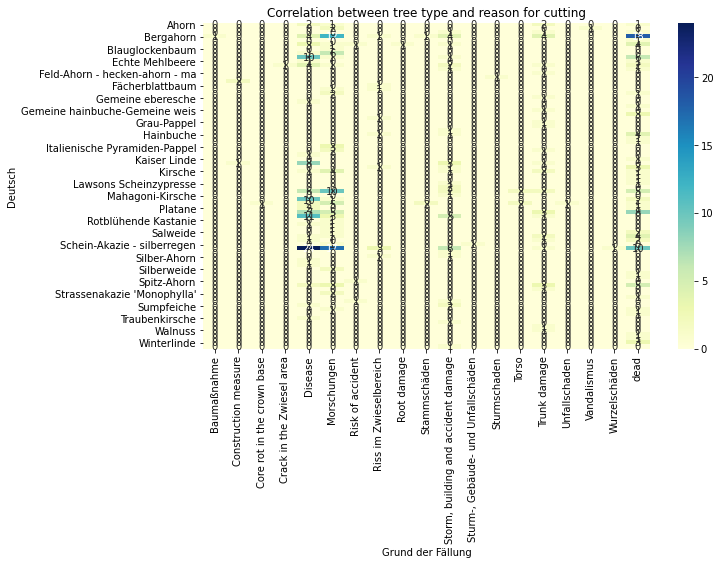

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_treescut, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Correlation between tree type and reason for cutting')
plt.show()

In [12]:
from scipy.stats import chi2_contingency

# chi-quadrat-Test
chi2, p, dof, expected = chi2_contingency(cross_tab_treescut)
print(f'Chi-squared value: {chi2}')
print(f'P-value: {p}')

Chi-squared value: 2078.528345621451
P-value: 1.4322415519821152e-27


# Locating the trees on a map

In [13]:
#Creating a map object and setting the initial view with the latitude and longitude of Düsseldorf
duesseldorf_coords = (51.2277, 6.7735)
map_tree_location = folium.Map(location=duesseldorf_coords, tiles="cartodb positron", zoom_start=12)

#Creating a second map object and setting the initial view with the latitude and longitude of Düsseldorf
map_tree_location2 = folium.Map(location=duesseldorf_coords, tiles="cartodb positron", zoom_start=12)

In [14]:
#Iterating through df_newtrees containing the tree locations and tree type, and add markers for each tree location to the map
for index, row in df_newtrees.iterrows():
    tree_coords1 = (row['latitude'], row['longitude'])
    popup_content1 = f"Tree Type: {row['baumart']}, Planting Year: {row['saison']}"
    marker1 = folium.Marker(location=tree_coords1, popup=popup_content1, icon=folium.Icon(color='green', icon='leaf')) 
    marker1.add_to(map_tree_location)

In [15]:
#Iterating through df_newtrees containing the tree locations and tree type, and add markers for each tree location to the second map
for index, row in df_newtrees.iterrows():
    tree_coords1 = (row['latitude'], row['longitude'])
    popup_content1 = f"Tree Type: {row['baumart']}, Planting Year: {row['saison']}"
    marker1 = folium.Marker(location=tree_coords1, popup=popup_content1, icon=folium.Icon(color='green', icon='leaf')) 
    marker1.add_to(map_tree_location2)
    
    #Iterating through df_treescut containing the tree locations and tree type, and add markers for each tree location to the second map
for index, row in df_treescut.iterrows():
    tree_coords2 = (row['Latitude'], row['Longitude'])
    popup_content2 = f"Tree Type: {row['Deutsch']}, Reason for cutting: {row['Grund der Fällung']}"
    marker2 = folium.Marker(location=tree_coords2, popup=popup_content2,  icon=folium.Icon(color='red', icon='leaf')) 
    marker2.add_to(map_tree_location2) 
    

In [16]:
#Save the map as an HTML file 
map_tree_location.save('new_trees_map.html')

#Save the second map as an HTML file 
map_tree_location2.save('new_and_cutted_trees_map.html')

In [17]:
map_tree_location

In [18]:
map_tree_location2

# Weather Data (Adding the coordinates)

In [19]:
# dropping the column "Unnamed: 0" in the weather datasets
df_Wetterstation_City = df_Wetterstation_City.drop(columns = "Unnamed: 0") 
df_Wetterstation_Uni = df_Wetterstation_Uni.drop(columns = "Unnamed: 0") 

In [20]:
### Adding the coordinates for the two weather stations

# Adding a new column "Latitude" to the two weather datasets
df_Wetterstation_City["Latitude"] = 51.24
df_Wetterstation_Uni["Latitude"] = 51.19

# Adding a new column "Longitude" to the two weather datasets
df_Wetterstation_City["Longitude"] = 6.79
df_Wetterstation_Uni["Longitude"] = 6.80

In [21]:
df_Wetterstation_City.head(100)

,Datum,Tmit,Sges,Rges,Latitude,Longitude
0,01.01.2012,"12,1",0,"5,7",51.24,6.79
1,02.01.2012,"8,3",0,"3,0",51.24,6.79
2,03.01.2012,"8,2",0,"2,8",51.24,6.79
3,04.01.2012,"6,8","0,7","5,7",51.24,6.79
4,05.01.2012,7,"0,5","17,4",51.24,6.79
...,...,...,...,...,...,...
95,05.04.2012,"7,1",0,"0,0",51.24,6.79
96,06.04.2012,"7,7","6,1","2,9",51.24,6.79
97,07.04.2012,"5,6","1,4","0,1",51.24,6.79
98,08.04.2012,"6,4","10,2","9,2",51.24,6.79


In [22]:
df_Wetterstation_Uni

,Datum,Tmit,Sges,Rges,Latitude,Longitude
0,01.04.2012,"5,2","10,4","0,0",51.19,6.8
1,02.04.2012,"6,4","2,6","0,0",51.19,6.8
2,03.04.2012,10,"6,7","0,5",51.19,6.8
3,04.04.2012,"9,2","1,4","0,0",51.19,6.8
4,05.04.2012,"6,8",0,"0,0",51.19,6.8
...,...,...,...,...,...,...
3160,27.12.2020,"4,6",0,"6,5",51.19,6.8
3161,28.12.2020,"4,1","2,3","0,6",51.19,6.8
3162,29.12.2020,"1,7","0,1",0,51.19,6.8
3163,30.12.2020,"3,2",0,"2,8",51.19,6.8


# Combining the datasets df_Grundwassermessstellen and the csv files with the groundwater levels into one dataset: df_groundwater

In [23]:
# Define the pattern for the CSV files (e.g., all CSV files in the current directory)
csv_files_pattern = 'Datasets/Groundwater/*.csv'  # Update the path to your dataset directory

# Get a list of file paths that match the pattern using glob
csv_file_paths = glob.glob(csv_files_pattern)

# Create an empty list to store DataFrames after processing
processed_dataframes = []

# Loop through each file path
for file_path in csv_file_paths:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path, sep=';', encoding="cp1252")
    
    # Get the values from the first row for 'Latitude', 'Longitude', and 'Street'
    latitude_value = df.loc[0, 'Latitude']
    longitude_value = df.loc[0, 'Longitude']
    street_value = df.loc[0, 'Street']
    
    # Fill the corresponding columns with the extracted values
    df['Latitude'] = latitude_value
    df['Longitude'] = longitude_value
    df['Street'] = street_value
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

# Concatenate the processed DataFrames
df_groundwater = pd.concat(processed_dataframes, ignore_index=True)

# Dropping the column 'Unnamed: 5' (Don't know where that came from)
df_groundwater = df_groundwater.drop(columns=['Unnamed: 5'])

df_groundwater['Latitude'] = df_groundwater['Latitude'].str.replace('.', '', 1)
df_groundwater['Longitude'] = df_groundwater['Longitude'].str.replace('.', '', 1)

# Converting the columns Latitude and Longitude to numeric values
df_groundwater['Latitude'] = pd.to_numeric(df_groundwater['Latitude'])
df_groundwater['Longitude'] = pd.to_numeric(df_groundwater['Longitude'])

# Renaming the columns x, y
df_groundwater.rename(columns = {'x':'Date', 'y':'groundwater'}, inplace = True)

# Formatting the 'Latitude' and 'Longitude' columns 
df_groundwater['Latitude'] = df_groundwater['Latitude'].apply(lambda value: '{:.6f}'.format(float(value) / 1000))
df_groundwater['Longitude'] = df_groundwater['Longitude'].apply(lambda value: '{:.6f}'.format(float(value) / 1000))

# Convert 'Latitude' and 'Longitude' columns from object to numeric
df_groundwater['Latitude'] = pd.to_numeric(df_groundwater['Latitude'])
df_groundwater['Longitude'] = pd.to_numeric(df_groundwater['Longitude'])

# Replacing commas in the column "groundwater" 
df_groundwater['groundwater'] = df_groundwater['groundwater'].str.replace(',', '.')

# Clean and convert "groundwater" column to numeric
df_groundwater['groundwater'] = pd.to_numeric(df_groundwater['groundwater'])

In [24]:
df_groundwater

,Date,groundwater,Latitude,Longitude,Street
0,29.06.1972,38.21,51.206063,6.860008,Am Ellerforst
1,25.07.1972,38.41,51.206063,6.860008,Am Ellerforst
2,15.08.1972,38.33,51.206063,6.860008,Am Ellerforst
3,20.09.1972,38.19,51.206063,6.860008,Am Ellerforst
4,11.10.1972,38.06,51.206063,6.860008,Am Ellerforst
...,...,...,...,...,...
230910,29.07.2023,25.95,51.227636,6.758231,Wildenbruchstraße
230911,30.07.2023,26.08,51.227636,6.758231,Wildenbruchstraße
230912,31.07.2023,26.21,51.227636,6.758231,Wildenbruchstraße
230913,01.08.2023,26.31,51.227636,6.758231,Wildenbruchstraße


# Creating a new dataset "monthly_groundwater" with the average groundwater levels for all 23 measuring points for every month of the year

In [25]:
# Convert "Date" column to datetime format
df_groundwater['Date'] = pd.to_datetime(df_groundwater['Date'], format='%d.%m.%Y')

# Extract year and month
df_groundwater['Year'] = df_groundwater['Date'].dt.year
df_groundwater['Month'] = df_groundwater['Date'].dt.month

# Group by measuring point, year, and month, calculate average groundwater
grouped = df_groundwater.groupby(['Latitude', 'Longitude', 'Street', 'Year', 'Month'])['groundwater'].mean().reset_index()

# Pivotieren der Daten, um Monate als Spalten und Durchschnittspegel als Werte zu haben
monthly_groundwater = grouped.pivot_table(index=['Latitude', 'Longitude', 'Street'], columns=['Month'], values='groundwater').reset_index()

# Renaming of the columns with the monthly groundwater levels
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_groundwater.columns = ['Latitude', 'Longitude', 'Street'] + month_names


In [26]:
monthly_groundwater

,Latitude,Longitude,Street,January,February,March,April,May,June,July,August,September,October,November,December
0,51.135152,6.915579,Wernigeroder Straße,40.459439,40.557567,40.615322,40.586998,40.524623,40.437551,40.353314,40.295674,40.212796,40.192365,40.240190,40.303192
1,51.170399,6.822083,Itterstraße,31.451185,31.664261,31.744998,31.664533,31.444823,31.391323,31.309326,31.072897,30.815248,30.624358,30.591517,30.828213
2,51.178304,6.875167,Schillstraße,37.252685,37.359011,37.472858,37.461231,37.407016,37.362000,37.315901,37.246774,37.190593,37.159403,37.138733,37.092339
3,51.206063,6.860008,Am Ellerforst,38.858740,39.015841,39.058213,38.970374,38.873682,38.803342,38.668935,38.589229,38.490567,38.498315,38.497550,38.574039
4,51.206063,6.860008,Bachstraße,28.381609,28.664250,28.736521,28.774962,28.508615,28.561160,28.396467,28.362002,28.014991,27.855537,27.684547,27.931687
5,51.206063,6.860008,Bahnhofstraße,30.891602,31.018410,31.195640,31.100064,31.193443,31.054050,31.008476,30.895498,30.855598,30.803304,30.781125,30.739714
6,51.206063,6.860008,Dechenweg,31.627038,31.865996,31.994473,31.930775,31.844817,31.849582,31.803993,31.689577,31.533418,31.459346,31.244559,31.334164
7,51.212214,6.858887,In den Kötten,38.711750,38.737599,38.868413,38.799687,38.697039,38.622959,38.513387,38.400402,38.358204,38.371292,38.446963,38.435194
8,51.216398,6.775534,Elisabethstraße,28.043039,28.275791,28.342654,28.342227,28.209512,28.155031,28.020481,27.822085,27.596681,27.421068,27.337341,27.550447
9,51.218968,6.848527,Gubener Straße,37.949315,38.045871,38.153152,38.089504,38.022548,37.952128,38.103053,37.814716,37.798398,37.738207,37.832311,37.747751


# Function that calculates the nearest groundwater measuring point of each tree (based on datasets "df_newtrees" and "monthly_groundwater")

# In the dataset "trees_with_groundwater" you can see for every tree the nearest groundwater measuring point ("Street") and the respective groundwater levels for every month (average)

In [27]:
# Create a vectorized function to calculate Haversine distance
def haversine_distance(coords1, coords2):
    lat1, lon1 = coords1
    lat2, lon2 = coords2
    
    r = 6371000  # Earth radius in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = r * c
    return distance

# Calculate distances for each tree and measuring point combination
tree_coords = df_newtrees[['latitude', 'longitude']].values
measuring_point_coords = monthly_groundwater[['Latitude', 'Longitude']].values

distances = cdist(tree_coords, measuring_point_coords, metric=haversine_distance)

# Find the index of the nearest measuring point for each tree
nearest_indices = np.argmin(distances, axis=1)

# Create a new column in the trees DataFrame to store the nearest measuring point index
df_newtrees['nearest_measuring_point'] = nearest_indices

# Merge the groundwater level data into the trees DataFrame
trees_with_groundwater = pd.merge(df_newtrees, monthly_groundwater, left_on='nearest_measuring_point', right_index=True, suffixes=('', '_measuring_point'))

# Renaming the columns latitude and longitude
trees_with_groundwater.rename(columns = {'latitude':'latitude_tree', 'longitude':'longitude_tree', 'Latitude': 'Latitude_water', 'Longitude': 'Longitude_water'}, inplace = True)

# Saving the dataset df_newtrees_water in a csv file
trees_with_groundwater.to_csv('Datasets/trees_with_groundwater.csv', index=False)


In [28]:
trees_with_groundwater

,saison,baumart,latitude_tree,longitude_tree,nearest_measuring_point,Latitude_water,Longitude_water,Street,January,February,March,April,May,June,July,August,September,October,November,December
0,2019/2020,Magnolie,51.234817,6.792643,14,51.228684,6.784439,Goltsteinstraße,28.453813,28.592284,28.673253,28.562865,28.491489,28.492736,28.460002,28.230620,28.084982,27.898384,27.892771,27.953164
1,2019/2020,Hainbuche,51.233857,6.776602,14,51.228684,6.784439,Goltsteinstraße,28.453813,28.592284,28.673253,28.562865,28.491489,28.492736,28.460002,28.230620,28.084982,27.898384,27.892771,27.953164
2,2019/2020,Zierapfel,51.234194,6.786298,14,51.228684,6.784439,Goltsteinstraße,28.453813,28.592284,28.673253,28.562865,28.491489,28.492736,28.460002,28.230620,28.084982,27.898384,27.892771,27.953164
3,2019/2020,Zierapfel,51.234508,6.786283,14,51.228684,6.784439,Goltsteinstraße,28.453813,28.592284,28.673253,28.562865,28.491489,28.492736,28.460002,28.230620,28.084982,27.898384,27.892771,27.953164
4,2019/2020,Zierapfel,51.234733,6.786272,14,51.228684,6.784439,Goltsteinstraße,28.453813,28.592284,28.673253,28.562865,28.491489,28.492736,28.460002,28.230620,28.084982,27.898384,27.892771,27.953164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,2021/2022,Hainbuche,51.128127,6.903630,0,51.135152,6.915579,Wernigeroder Straße,40.459439,40.557567,40.615322,40.586998,40.524623,40.437551,40.353314,40.295674,40.212796,40.192365,40.240190,40.303192
385,2021/2022,Zierkirsche,51.129036,6.908177,0,51.135152,6.915579,Wernigeroder Straße,40.459439,40.557567,40.615322,40.586998,40.524623,40.437551,40.353314,40.295674,40.212796,40.192365,40.240190,40.303192
386,2021/2022,Zierkirsche,51.129067,6.908376,0,51.135152,6.915579,Wernigeroder Straße,40.459439,40.557567,40.615322,40.586998,40.524623,40.437551,40.353314,40.295674,40.212796,40.192365,40.240190,40.303192
387,2021/2022,Kugel-Trompetenbaum,51.129229,6.901879,0,51.135152,6.915579,Wernigeroder Straße,40.459439,40.557567,40.615322,40.586998,40.524623,40.437551,40.353314,40.295674,40.212796,40.192365,40.240190,40.303192
